**Continuation (2) -- Concluding work: Best model is an LSTM model, with time dependence ensured by using an explicit vector autoregression (lag = 1 here)**

This is a continuation of the previous notebook.

The steps there are repeated here:

(1) Each of the 51 data sets will be now kept separate, with time order preserved.

(2) Some of the data sets have a few missing rows. These are now filled by the last existing row, which seems more correct than using the mean value. Thus all the data sets are now of length 5000 (at 50 Hz, this means 100 s of observation).

(3) The split is the same as before: train/validate/test = 70%/15%/15%, however now it occurs on the data set level, thus it is train/validate/test = first 35 data sets/next 8 data sets/last 8 data sets.

(4) In fitting the models we use shuffle=False and a batch_size = 5000 (the size of each data set).

Now, in addition, we use an explicit vector autoregression strategy to first re-process the data:

(5) First we do what is normally done in autoregression: the present depends on some number of time steps n in the past (see, e.g., https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ and https://www.slideshare.net/databricks/time-series-forecasting-using-recurrent-neural-network-and-vector-autoregressive-model-when-and-how-with-jeffrey-yau):

y_vector(t) =
f(X_matrix(t-n), y_vector(t-n), X_matrix(t-n+1), y_vector(t-n+1), ..., X_matrix(t-n+1), y_vector(t-n+1), ..., X_matrix(t-1), y_vector(t-1), X_matrix(t-1), y_vector(t-1))

Here we take n = lag_steps = 1, so:

y_vector(t) = f(X_matrix(t-1), y_vector(t-1))

To start, we forecast the present by looking just one lag step into the past (lag = 1 here). Thus the X matrices (matrices: train, valid, test) will be shifted and extended relative to the corresponding y vectors (see below for details).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/challenge')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import joblib as joblib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

features, labels = joblib.load('/content/drive/My Drive/challenge/data.dat')

print(len(features))
print(len(labels))

51
51


In [3]:
n_samples = len(features)
print(n_samples)
for i in range(n_samples):
  print(features[i].shape, labels[i].shape)

51
(4979, 30) (4979, 5)
(4966, 30) (4966, 5)
(4944, 30) (4944, 5)
(4966, 30) (4966, 5)
(4966, 30) (4966, 5)
(4958, 30) (4958, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(4937, 30) (4937, 5)
(4959, 30) (4959, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(4974, 30) (4974, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30) (5000, 5)
(5000, 30)

In [4]:
for i in range(len(features)):
  print(features[i].shape[0])

4979
4966
4944
4966
4966
4958
5000
5000
4937
4959
5000
5000
5000
5000
5000
5000
5000
4974
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


In [5]:
n_time_steps = min([features[i].shape[0] for i in range(len(features))])
print(n_time_steps)
n_time_steps = max([features[i].shape[0] for i in range(len(features))])
print(n_time_steps)
n_features = features[-1].shape[1]
n_labels = labels[-1].shape[1]
print(n_samples, n_time_steps, n_features)
print(n_labels)

4937
5000
51 5000 30
5


In [6]:
features_extended = []
labels_extended = []
for i in range(n_samples):
  features_extended.append(np.full((n_time_steps, n_features), np.NaN))
  labels_extended.append(np.full((n_time_steps, n_labels), np.NaN))

print(features_extended)
print(labels_extended)

[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan

In [7]:
features_extended[0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [8]:
labels_extended[0]

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [9]:
# Instead of imputing mean for the missing rows (nan values), use the last non-nan row;
# this intuitively seems more proper to avoid an unphysical sudden change in a feature or label 
#for i in range(n_samples):
#  features_extended[i] = np.where(np.isnan(features_extended[i]), np.ma.array(features_extended[i], mask=np.isnan(features_extended[i])).mean(axis=0), features_extended[i])

#for i in range(n_samples):
#  labels_extended[i] = np.where(np.isnan(labels_extended[i]), np.ma.array(labels_extended[i], mask=np.isnan(labels_extended[i])).mean(axis=0), labels_extended[i])

for i in range(n_samples):
  for j in range(features[i].shape[0]):
      features_extended[i][j,:] = features[i][j,:]
      labels_extended[i][j,:] = labels[i][j,:]
  for j in range(features[i].shape[0], features_extended[i].shape[0]):
    features_extended[i][j,:] = features[i][-1,:]
    labels_extended[i][j,:] = labels[i][-1,:]

In [10]:
features_extended[0]

array([[341., 347., 341., ..., 289., 319., 253.],
       [341., 347., 341., ..., 289., 319., 253.],
       [341., 348., 341., ..., 289., 320., 253.],
       ...,
       [353., 366., 352., ..., 297., 329., 253.],
       [353., 366., 352., ..., 297., 329., 253.],
       [353., 366., 352., ..., 297., 329., 253.]])

In [11]:
features_extended[6]

array([[341., 351., 344., ..., 289., 326., 249.],
       [343., 351., 344., ..., 289., 326., 250.],
       [343., 352., 345., ..., 289., 326., 250.],
       ...,
       [347., 354., 342., ..., 292., 328., 250.],
       [347., 354., 341., ..., 292., 327., 250.],
       [348., 354., 341., ..., 292., 327., 251.]])

In [12]:
labels_extended[0]

array([[ 0.22357153,  0.99496208,  0.9940664 ,  0.99074757,  0.91400573],
       [ 0.41729854,  0.966014  ,  0.9855725 ,  0.98592047,  0.95746513],
       [ 0.48011878,  0.96245373,  0.97715618,  0.98331914,  0.96457863],
       ...,
       [ 0.66263708, -0.01864924,  0.97818341,  0.99152175,  0.97322957],
       [ 0.66263708, -0.01864924,  0.97818341,  0.99152175,  0.97322957],
       [ 0.66263708, -0.01864924,  0.97818341,  0.99152175,  0.97322957]])

In [13]:
labels_extended[6]

array([[0.43893767, 0.92950599, 0.96534301, 0.98771034, 0.97779767],
       [0.43861785, 0.93203866, 0.96526262, 0.98699533, 0.97795311],
       [0.44241947, 0.9371996 , 0.96759891, 0.98651075, 0.97713577],
       ...,
       [0.50392182, 0.95871953, 0.97180332, 0.96983296, 0.96772247],
       [0.50635417, 0.96951422, 0.97576246, 0.97381956, 0.9723318 ],
       [0.51060372, 0.97616196, 0.97973472, 0.97788348, 0.9745093 ]])

In [14]:
X = np.array(features_extended)
print(X.shape)
#X = np.vstack(X)
#print(X.shape)

(51, 5000, 30)


In [15]:
# Normalize data to have feature values between 0 and 1:
# divide by max possible feature value (1024 = 10-bit resolution)
# Can also save memory by reducing resolution to 4 bytes
X = X.astype('float32') / 1024.0 # below will also use StandardScaler, will train on train set, better for NN applications
np.min(X), np.max(X), np.mean(X), np.std(X)

(0.08300781, 0.41796875, 0.2788339, 0.055174924)

In [16]:
y = np.array(labels_extended)
print(y.shape)
#y = np.vstack(y)
#print(y.shape)

(51, 5000, 5)


In [17]:
# Can also safely reduce resolution of the labels to 4 bytes
y = y.astype('float32')
np.min(y), np.max(y), np.mean(y), np.std(y)

(-0.85305923, 0.9999999, 0.4763818, 0.61013037)

In [18]:
print(X.shape)
print(y.shape)

(51, 5000, 30)
(51, 5000, 5)


In [19]:
# same splitting percentages:
# train/valid_test split = 70%/30%, valid/test split = 50%/50%
# Therefore, train/valid/test split = 70%/15%/15%

# perhaps should not use this for such time series data, but the splitting code below leads to problems in the NN fits 
# X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.30, random_state=42)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.50, random_state=42)

###

# Preserve the time information!!!

# The splitting code below leads to problems in the NN fits so dont use it (maybe only with RNNs)
# Be careful in splitting time series data: using train_test_split will randomly reorder the data
# The simple code here does the same split without reordering any data
# train / validate / test split = first 70% / next 15% / last 15%

print(n_samples)
n_samples = X.shape[0]
print(n_samples)
n_samples_train = int(X.shape[0]*0.70)
print(n_samples_train)

X_train = X[:n_samples_train]
X_valid_test = X[n_samples_train:]
y_train = y[:n_samples_train]
y_valid_test = y[n_samples_train:]

n_samples_valid_test = X_valid_test.shape[0]
print(n_samples_valid_test)
n_samples_valid = int(X_valid_test.shape[0]*0.50)
n_samples_test = int(X_valid_test.shape[0]*0.50)
print(n_samples_valid)
print(n_samples_test)
X_valid = X_valid_test[:int(X_valid_test.shape[0]*0.50)]
X_test = X_valid_test[int(X_valid_test.shape[0]*0.50):]
y_valid = y_valid_test[:int(X_valid_test.shape[0]*0.50)]
y_test = y_valid_test[int(X_valid_test.shape[0]*0.50):]

# or can use this:

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Preserve the time information by using shuffle=False
# X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.30, shuffle=False)
# X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.50, shuffle=False)
###

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

51
51
35
16
8
8
(51, 5000, 30) (51, 5000, 5)
(35, 5000, 30) (35, 5000, 5)
(8, 5000, 30) (8, 5000, 5) (8, 5000, 30) (8, 5000, 5)


X arrays: convert to the type of 3d arrays expected by LSTM: X_array(data_lines, lag_steps, n_features_shifted).

In [20]:
# X arrays: convert to the type of 3d arrays expected by LSTM: X_array(data_lines, lag_steps, n_features_shifted)

# first do what is normally done in autoregression: the present depends on some number of time steps n in the past:
# see, e.g., https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# y_vector(t) = f(X_matrix(t-n), y_vector(t-n), X_matrix(t-n+1), y_vector(t-n+1), ...,  X_matrix(t-n+1), y_vector(t-n+1), ..., X_matrix(t-1), y_vector(t-1), X_matrix(t-1), y_vector(t-1))
# here we take n = lag_steps = 1, so:
# y_vector(t) = f(X_matrix(t-1), y_vector(t-1))

# to start, forecast the present by looking just one lag step into the past
lag_steps = 1
n_features_shifted = lag_steps*(n_features+n_labels)

X_train_shifted = np.full((n_samples_train, n_time_steps, n_features_shifted), np.NaN)
y_train_shifted = np.full((n_samples_train, n_time_steps, n_labels), np.NaN)
for i in range(n_samples_train):
  X_train_shifted[i] = np.hstack((X_train[i], y_train[i]))
  y_train_shifted[i, 0:-1, :] = y_train[i, lag_steps:, :]

X_valid_shifted = np.full((n_samples_valid, n_time_steps, n_features_shifted), np.NaN)
y_valid_shifted = np.full((n_samples_valid, n_time_steps, n_labels), np.NaN)
for i in range(n_samples_valid):
  X_valid_shifted[i] = np.hstack((X_valid_test[i], y_valid_test[i]))
  y_valid_shifted[i, 0:-1, :] = y_valid_test[i, lag_steps:, :]

X_test_shifted = np.full((n_samples_test, n_time_steps, n_features_shifted), np.NaN)
y_test_shifted = np.full((n_samples_test, n_time_steps, n_labels), np.NaN)
for i in range(n_samples_test):
  X_test_shifted[i] = np.hstack((X_test[i], y_test[i]))
  y_test_shifted[i, 0:-1, :] = y_test[i, lag_steps:, :]

print(X_train_shifted.shape, y_train_shifted.shape)
print(X_valid_shifted.shape, y_valid_shifted.shape)
print(X_test_shifted.shape, y_test_shifted.shape)
print()

print('X_train_shifted:')
print(X_train_shifted)
print()

print('y_train_shifted:')
print(y_train_shifted)
print()

print('y_valid_shifted:')
print(y_valid_shifted)
print()

print('y_test_shifted:')
print(y_test_shifted)
print()

(35, 5000, 35) (35, 5000, 5)
(8, 5000, 35) (8, 5000, 5)
(8, 5000, 35) (8, 5000, 5)

X_train_shifted:
[[[ 0.33300781  0.33886719  0.33300781 ...  0.99406642  0.99074757
    0.91400576]
  [ 0.33300781  0.33886719  0.33300781 ...  0.98557252  0.98592049
    0.95746511]
  [ 0.33300781  0.33984375  0.33300781 ...  0.97715616  0.98331916
    0.96457863]
  ...
  [ 0.34472656  0.35742188  0.34375    ...  0.97818339  0.99152178
    0.97322959]
  [ 0.34472656  0.35742188  0.34375    ...  0.97818339  0.99152178
    0.97322959]
  [ 0.34472656  0.35742188  0.34375    ...  0.97818339  0.99152178
    0.97322959]]

 [[ 0.33105469  0.33691406  0.33007812 ...  0.99334639  0.9781878
    0.92460269]
  [ 0.33203125  0.33691406  0.33007812 ...  0.99334639  0.9781878
    0.92460269]
  [ 0.33203125  0.33691406  0.33007812 ...  0.94155204  0.94964945
    0.94444561]
  ...
  [ 0.34082031  0.34765625  0.3359375  ...  0.98878533  0.98820382
    0.98271888]
  [ 0.34082031  0.34765625  0.3359375  ...  0.98878533  0

In [21]:
# Again, instead of imputing mean for the missing row (nan values), use the last non-nan row
# or can just delete the row, but that will change the data size
# hopefully, with 5000 time steps, epeating the last row will not cause any negative artifacts

for i in range(n_samples_train):
  y_train_shifted[i, -1, :] = y_train_shifted[i, -2, :]

for i in range(n_samples_valid):
  y_valid_shifted[i, -1, :] = y_valid_shifted[i, -2, :]

for i in range(n_samples_test):
  y_test_shifted[i, -1, :] = y_test_shifted[i, -2, :]

print(X_train_shifted.shape, y_train_shifted.shape)
print(X_valid_shifted.shape, y_valid_shifted.shape)
print(X_test_shifted.shape, y_test_shifted.shape)
print()

print('X_train_shifted:')
print(X_train_shifted)
print()

print('y_train_shifted:')
print(y_train_shifted)
print()

print('y_valid_shifted:')
print(y_valid_shifted)
print()

print('y_test_shifted:')
print(y_test_shifted)
print()

(35, 5000, 35) (35, 5000, 5)
(8, 5000, 35) (8, 5000, 5)
(8, 5000, 35) (8, 5000, 5)

X_train_shifted:
[[[ 0.33300781  0.33886719  0.33300781 ...  0.99406642  0.99074757
    0.91400576]
  [ 0.33300781  0.33886719  0.33300781 ...  0.98557252  0.98592049
    0.95746511]
  [ 0.33300781  0.33984375  0.33300781 ...  0.97715616  0.98331916
    0.96457863]
  ...
  [ 0.34472656  0.35742188  0.34375    ...  0.97818339  0.99152178
    0.97322959]
  [ 0.34472656  0.35742188  0.34375    ...  0.97818339  0.99152178
    0.97322959]
  [ 0.34472656  0.35742188  0.34375    ...  0.97818339  0.99152178
    0.97322959]]

 [[ 0.33105469  0.33691406  0.33007812 ...  0.99334639  0.9781878
    0.92460269]
  [ 0.33203125  0.33691406  0.33007812 ...  0.99334639  0.9781878
    0.92460269]
  [ 0.33203125  0.33691406  0.33007812 ...  0.94155204  0.94964945
    0.94444561]
  ...
  [ 0.34082031  0.34765625  0.3359375  ...  0.98878533  0.98820382
    0.98271888]
  [ 0.34082031  0.34765625  0.3359375  ...  0.98878533  0

In [22]:
print('n_features_shifted: ', n_features_shifted)
n_features_shifted = X_train_shifted.shape[2]
print('n_features_shifted: ', n_features_shifted)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# scaler only operates on 2d arrays so first transform to 2d, then scale, then transform back to 3d

# transform to 2d

print(X_train_shifted.shape)
X_train_shifted = np.vstack(X_train_shifted)
print(X_train_shifted.shape)

print(X_valid_shifted.shape)
X_valid_shifted = np.vstack(X_valid_shifted)
print(X_valid_shifted.shape)

print(X_test_shifted.shape)
X_test_shifted = np.vstack(X_test_shifted)
print(X_test_shifted.shape)

print()

# train the scaler on train data only, then apply to all arrays (to prevent data leakage)

### from sklearn.preprocessing import MinMaxScaler
### scaler = MinMaxScaler()

X_train_shifted = scaler.fit_transform(X_train_shifted)
X_valid_shifted = scaler.transform(X_valid_shifted)
X_test_shifted = scaler.transform(X_test_shifted)

# y arrays: convert to 3d arrays expected by LSTM

X_train_shifted = X_train_shifted.reshape(n_samples_train*n_time_steps, lag_steps, n_features_shifted)
X_valid_shifted = X_valid_shifted.reshape(n_samples_valid*n_time_steps, lag_steps, n_features_shifted)
X_test_shifted = X_test_shifted.reshape(n_samples_test*n_time_steps, lag_steps, n_features_shifted)

# y arrays: convert to regular 2d arrays: y_array(data_lines, n_labels)

y_train_shifted = y_train_shifted.reshape(n_samples_train*n_time_steps, n_labels)
y_valid_shifted = y_valid_shifted.reshape(n_samples_valid*n_time_steps, n_labels)
y_test_shifted = y_test_shifted.reshape(n_samples_test*n_time_steps, n_labels)

print(X_train_shifted.shape, y_train_shifted.shape)
print(X_valid_shifted.shape, y_valid_shifted.shape)
print(X_test_shifted.shape, y_test_shifted.shape)
print()

n_features_shifted:  35
n_features_shifted:  35
(35, 5000, 35)
(175000, 35)
(8, 5000, 35)
(40000, 35)
(8, 5000, 35)
(40000, 35)

(175000, 1, 35) (175000, 5)
(40000, 1, 35) (40000, 5)
(40000, 1, 35) (40000, 5)



In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#  tensorflow 2.0 library provides functions for deep neural networks 
import tensorflow
print(tensorflow.__version__)

from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM

2.4.1


**Model: LSTM (same architecture as before) fit5, now applied to the extended X_train matrix (with time shifted and additional features, lag = 1)**

In [24]:
input_shape0, input_shape1, input_shape2 = X_train_shifted.shape[0], X_train_shifted.shape[1], X_train_shifted.shape[2]
print(input_shape0, input_shape1, input_shape2)
output_shape0, output_shape1 = y_train_shifted.shape[0], y_train_shifted.shape[1]
print(output_shape0, output_shape1)

model = Sequential()
# Add a LSTM layer with 128 internal units.
model.add(LSTM(128, input_shape=(X_train_shifted.shape[1], X_train_shifted.shape[2])))
# Add a Dense layer with 5 units.
model.add(Dense(y_train_shifted.shape[1], activation='linear'))

model.summary()

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

175000 1 35
175000 5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               83968     
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 84,613
Trainable params: 84,613
Non-trainable params: 0
_________________________________________________________________


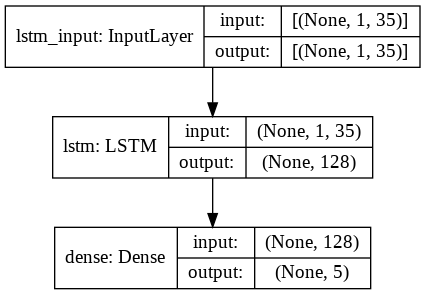

In [25]:
# plot the graph of the model and save to file
plot_model(model, to_file='model4_lstm.png', show_shapes=True, show_layer_names=True)

In [26]:
batch_size = 5000 # this is the time duration = 5000/(50 Hz) = 100 seconds, of each independent measurement set
epochs = 75

In [27]:
%%time 

history5_lstm = model.fit(X_train_shifted, y_train_shifted, batch_size=batch_size, 
                                  epochs=epochs,
                                  verbose=1,
                                  validation_data=(X_valid_shifted, y_valid_shifted), shuffle=False)

Epoch 1/75
35/35 [==============================] - 4s 38ms/step - loss: 0.5071 - mean_squared_error: 0.5071 - val_loss: 0.1591 - val_mean_squared_error: 0.1591
Epoch 2/75
35/35 [==============================] - 0s 11ms/step - loss: 0.1834 - mean_squared_error: 0.1834 - val_loss: 0.2651 - val_mean_squared_error: 0.2651
Epoch 3/75
35/35 [==============================] - 0s 10ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - val_loss: 0.1584 - val_mean_squared_error: 0.1584
Epoch 4/75
35/35 [==============================] - 0s 10ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0826 - val_mean_squared_error: 0.0826
Epoch 5/75
35/35 [==============================] - 0s 11ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - val_loss: 0.0670 - val_mean_squared_error: 0.0670
Epoch 6/75
35/35 [==============================] - 0s 10ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0570 - val_mean_squared_error: 0.0570
Epoch 7/75
35/35 [================

In [28]:
def plot_history(history):
    
    #-----------------------------------------------------------
    # Retrieve results on training and validation data sets
    # for each training epoch
    #-----------------------------------------------------------
    
    mse      = history.history['mean_squared_error']
    val_mse  = history.history['val_mean_squared_error']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']
    epochs   = range(1,len(mse)+1) 
    
    plt.rcParams['font.size'] = 16
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    
    #------------------------------------------------
    # Plot training and validation mse per epoch
    #------------------------------------------------
    ax1.plot(epochs, mse,  label='Training mse')
    ax1.plot(epochs, val_mse,  label='Validation mse')
    ax1.set_title('Loss = MSE')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('mse')
    #ax1.set_ylim(0.5,1.2)
    ax1.legend()

    #------------------------------------------------
    # Plot training and validation rmse per epoch
    #------------------------------------------------
    ax2.plot(epochs, np.sqrt(mse),  label='Training rmse')
    ax2.plot(epochs, np.sqrt(val_mse),  label='Validation rmse')
    ax2.set_title('RMSE')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('rmse')
    #ax2.set_ylim(0.5,1.2)
    ax2.legend()

    fig.tight_layout()
    plt.show()

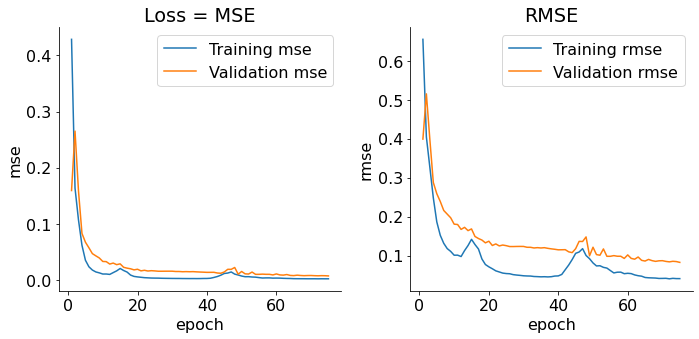

In [29]:
plot_history(history5_lstm)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_loss, test_mse = model.evaluate(X_test_shifted, y_test_shifted, batch_size=batch_size, verbose=2)
test_rmse = np.sqrt(test_mse)
y_test_shifted_pred = model.predict(X_test_shifted)
test_mae = mean_absolute_error(y_test_shifted, y_test_shifted_pred)
print('test_loss = test_mse, test_rmse, test_mae')
print("          %8.4f  %8.4f  %8.4f" % (test_mse, test_rmse, test_mae))

8/8 - 0s - loss: 0.0074 - mean_squared_error: 0.0074
test_loss = test_mse, test_rmse, test_mae
            0.0074    0.0862    0.0676


In [42]:
from tabulate import tabulate
#tabulate.PRESERVE_WHITESPACE = True

print(tabulate([
  ["Data size", "Method",             "params", "Fit name", "Lr",  "Decay", "Epoch", "Run time [mm:ss]", "train_rmse", "test_rmse", "test_mae"],
  [ 25000, "SVR",                      "",          "0a",       "",     "",      "",      ">10:00",          "0.3742",     "0.1400",   "0.0200"],
  [ 25000, "ANN (hidden:  60, 40,  -)", " 4,505",   "1a",       "1e-3", 0.9,      75,     "",                 0.0755,       "",        ""],
  [ 25000, "ANN (hidden:  60, 40,  -)", " 4,505",   "1a",       "1e-3", 0.9,     150,     " 03:03",          "0.0670",      0.0789,     0.0443],
  ["-----------", "---------------------------------------------", "--------", "----------", "-----", "-------", "-------", "------------------", "------------", "-----------", "----------"],
  ["", "", "", "", "", "", "", "", "", "", ""],

  [254649, "ANN (hidden:  60, 40,  -)", " 4,505",   "1 ",       "1e-3", 0.9,      75,     " 13:55",           0.1421,       0.1433,     0.0891],
  [254649, "ANN (hidden: 100, 50, 25)", " 9,555",   "2 ",       "1e-3", 0.9,      75,     " 14:36",           0.1086,       0.1133,     0.0618],
  [254649, "ANN (hidden: 300, 30,  -)", "18,485",   "3 ",       "1e-3", 0.9,      75,     " 14:09",          "0.1100",     "0.1140",    0.0678],
  ["-----------", "---------------------------------------------", "--------", "----------", "-----", "-------", "-------", "------------------", "------------", "-----------", "----------"],
  ["", "", "", "", "", "", "", "", "", "", ""],

  ["255000^1,2", "LSTM, explicit lag: 0   (internal units: 128)", "82,053",  "4b", "1e-3", 0.9, "12^3", "00:04", 0.3342,     0.5453,     0.4128],
  ["255000^1,2", "LSTM, explicit lag: 0   (internal units: 128)", "82,053",  "4a", "1e-3", 0.9, 75,     "00:20", 0.2472,     0.6251,     0.4725],
  ["255000^1,2", "LSTM, explicit lag: 1^4 (internal units: 128)", "84,613^3","5 ", "1e-3", 0.9, 75,     "00:36", 0.0447,     0.0862,     0.0676]],
  headers="firstrow"))
print()

print('^1 In these fits, unlike in the preceding fits, the few missing data rows in each set were interpolated as the last present row in that set.')
print('^2 In these fits, unlike in the preceding fits, the data was not shuffled; i.e., the data sets were not mixed, and also, time order was maintained in each set.')
print('^3 With early stopping (patience = 3).')
print('^4 A non-zero time lag refers to treating the vector autoregression problem by introducing an explicit lag, as in')
print('   https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/. Here, this introduces an additional 5 features (preceding values of y1-y5)')
print('   into X_train and accounts for the increase in the number of parameters.')

#print(np.sqrt(0.0020))

Data size    Method                                         params    Fit name    Lr     Decay    Epoch    Run time [mm:ss]    train_rmse    test_rmse    test_mae
-----------  ---------------------------------------------  --------  ----------  -----  -------  -------  ------------------  ------------  -----------  ----------
25000        SVR                                                      0a                                   >10:00              0.3742        0.1400       0.0200
25000        ANN (hidden:  60, 40,  -)                      4,505     1a          1e-3   0.9      75                           0.0755
25000        ANN (hidden:  60, 40,  -)                      4,505     1a          1e-3   0.9      150      03:03               0.0670        0.0789       0.0443
-----------  ---------------------------------------------  --------  ----------  -----  -------  -------  ------------------  ------------  -----------  ----------

254649       ANN (hidden:  60, 40,  -)            

**Final conclusions**

The table above summarizes results from the preceding two notebooks and this final notebook. With a CNN, fit2 performed best (test data rmse = 0.1133; if we take 60 degrees as a typical angle, this is an error of about 7.5 degrees). However, the time order in fits 0-3 was not respected, and thus these models at best present average predictions. To better, we need to preserve the time order, which was done in fits 4-5, and which also used a memory-aware LSTM rather than a memory-less ANN as before. Further, in fit5 we introduced additional explicit time dependence, with a lag of 1 time step. As can be seen, fit5 performs better (test data rmse = 0.0862; if we take 60 degrees as a typical angle, this is an error of about 5.7 degrees; an improvement of 24% over fit2). Also, importantly, the time for the fit was tremendously reduced (fit2, fully connected ANN with three hidden layers, wall time for the fit: about 14 minutes; versus fit5, single layer LSTM, wall time for the fit: 36 seconds; a reductions of about a factor of 28; with both fits run on the same data and hardware). This increase in speed of the LSTM model is also expected to be important in applications when making real-time predictions.

The final result in best model, fit5, with vector autoregression and an LSTM, with a typical error of about 5 degrees (depending on finger and bend angle) is an improvement over the preceding models and fits in this work. Of course, given addtional time, we could do better by exploring other LSTM architectures and tuning the hyperparameters.
